change output to binary list to a single float value, which will be the sum of the target outputs.

In [40]:
import torch
import torch.nn as nn
import math
import pandas as pd
from datetime import datetime as dt, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 42  # choose any seed you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



cuda


In [41]:
# hyperparameters for dataset and dataloader
input_size = 100
target_size = 5
batch_size = 16

# hyperparameters for model
num_features = 1  # 입력 시퀀스의 특징 수 (예: open, close 가격)

d_model = 64
n_heads = 2
num_encoder_layers = 2
d_ff = 256
dropout_rate = 0.1
lstm_hidden_size = 64
num_lstm_layers = 2

# hyperparameters for training, testing
learning_rate = 0.01
num_epochs = 100

In [42]:
class PriceDataset(Dataset):
    def __init__(self, item, timespan, start_date_str, end_date_str, input_window_size, target_window_size):
        self.directory = f'C:/Github/DL-FinalProject/csvfiles/{item}/'
        self.input_window_size = input_window_size
        self.target_window_size = target_window_size
        self.columns = [1, 4]  # Adjust as needed for zero-based indexing in NumPy
        self.data = self.load_data(start_date_str, end_date_str)

    def load_data(self, start_date_str, end_date_str):
        start_date = dt.strptime(start_date_str, '%Y-%m-%d').date()
        end_date = dt.strptime(end_date_str, '%Y-%m-%d').date()
        all_data = []

        for filename in os.listdir(self.directory):
            # Extract date from filename
            file_date_str = '-'.join(filename.split('-')[2:]).split('.')[0]
            file_date = dt.strptime(file_date_str, '%Y-%m-%d').date()

            if start_date <= file_date <= end_date:
                file_path = os.path.join(self.directory, filename)
                # Use NumPy to read the CSV file
                data = np.loadtxt(file_path, delimiter=',', usecols=self.columns, skiprows=1)
                # print(f"Reading file: {filename}, Data shape: {data.shape}")  # Debugging print
                all_data.append(data)

        # Concatenate all data arrays
        combined_data = np.vstack(all_data)
        # print(f"Shape of the combined data: {combined_data.shape}")
        return combined_data

    def __len__(self):
        return len(self.data) - self.input_window_size - self.target_window_size + 1

    def __getitem__(self, idx):
        if idx + self.input_window_size + self.target_window_size > len(self.data):
            raise IndexError("Index out of bounds")

        window_data = self.data[idx:idx + self.input_window_size + self.target_window_size]
        open_prices = window_data[:, 0]  # Open prices column
        close_prices = window_data[:, 1]  # Close prices column
        percentage_changes = ((close_prices - open_prices) * 100 / open_prices)
        input_data = torch.tensor(percentage_changes[:self.input_window_size], dtype=torch.float32)
        target_data = torch.tensor(percentage_changes[self.input_window_size:], dtype=torch.float32)
        return idx, (input_data, target_data)

In [43]:
# 포지셔널 인코딩 클래스
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 시계열 트랜스포머 모델 클래스
class TimeSeriesTransformerModel(nn.Module):
    def __init__(self, num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size):
        super(TimeSeriesTransformerModel, self).__init__()
        self.d_model = d_model

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        
        # Linear layer to transform LSTM output to match Transformer d_model size
        self.linear1 = nn.Linear(lstm_hidden_size, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout_rate)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.attention_weights = nn.Parameter(torch.randn(input_size, 1))


        # Output layer
        self.out = nn.Linear(d_model, target_size)

    def forward(self, src):
        # LSTM layer
        lstm_out, _ = self.lstm(src)
        # lstm_out: [batch_size, sequence_length, lstm_hidden_size]

        # Transform LSTM output to match Transformer d_model size
        src = self.linear1(lstm_out) * math.sqrt(self.d_model)
        # src: [batch_size, sequence_length, d_model]

        # Positional Encoding and Transformer
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # output: [batch_size, sequence_length, d_model]

        # 가중치 평균 계산을 위한 어텐션 적용
        attention_weights = torch.softmax(self.attention_weights, dim=0)
        output = torch.matmul(output.transpose(1, 2), attention_weights).squeeze(-1)
        # output: [batch_size, d_model]

        # 선형 레이어를 통과시켜 최종 출력 생성 / 시그모이드는 BCEwithLogitsLoss function에서 사용
        output = self.out(output)
        # output: [batch_size, target_size]

        output = output.sum(dim=1)

        return output

In [44]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_indices, (input_data, target_data) in train_loader:
        optimizer.zero_grad()
        
        # Data dimension change and move to device
        input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
        target_data = target_data.sum(dim=1).to(device)  # [32, 5]

        # Model prediction
        output = model(input_data)

        # Loss calculation and backpropagation
        loss = criterion(output, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_indices[0] % 100000 == 0:
            # print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
            print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(train_loader)

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_indices, (input_data, target_data) in test_loader:
            # Data dimension change and move to device
            input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
            target_data = target_data.sum(dim=1).to(device)  # [32, 5]

            # Model prediction
            output = model(input_data)

            # Loss calculation
            loss = criterion(output, target_data)
            total_loss += loss.item()


            if batch_indices[0] % 100000 == 0:
                # print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
                print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(test_loader)


In [45]:
# Example usage
train_dataset = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2021-12-31', input_window_size=input_size, target_window_size=target_size)
test_dataset = PriceDataset('BTCUSDT', '1m', '2023-01-01', '2023-03-01', input_window_size=input_size, target_window_size=target_size)
# print(train_dataset.__len__())
# print(test_dataset.__len__())

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # 학습 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트 데이터 로더


# 모델 인스턴스 생성
model = TimeSeriesTransformerModel(num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size)
model = model.to(device)


# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [46]:
# def test_first_batches(model, data_loader, criterion, device, num_batches=20):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         for i, (batch_indices, (input_data, target_data)) in enumerate(data_loader):
#             if i >= num_batches:
#                 break  # Only test the first 20 batches

#             # Data dimension change and move to device
#             input_data = input_data.unsqueeze(-1).to(device)  # Reshape for the model if necessary
#             target_data = target_data.sum(dim=1).to(device)

#             # Model prediction
#             output = model(input_data)

#             # Calculate loss
#             loss = criterion(output, target_data)

#             # Print batch information
#             print(f"Batch {i + 1}/{num_batches}")
#             print(f"Input Data: {input_data}")
#             print(f"Target Data: {target_data}")
#             print(f"Output Data: {output}")
#             print(f"Loss: {loss.item()}\n")

# # Usage of the testing function
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Assuming train_dataset is defined
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # Assuming test_dataset is defined
# criterion = nn.BCEWithLogitsLoss()  # Assuming you are using BCEWithLogitsLoss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Test the first 20 batches of the training data
# print("Testing on Training Data:")
# test_first_batches(model, train_loader, criterion, device)

# # Test the first 20 batches of the test data
# print("Testing on Test Data:")
# test_first_batches(model, test_loader, criterion, device)

No pre-trained model found. Initializing a new model.
Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0049872263334691525
Inside training loop. Batch indices: 200000, loss value: 0.0070991129614412785
Inside training loop. Batch indices: 300000, loss value: 0.005911640822887421
Inside training loop. Batch indices: 400000, loss value: 0.005232562776654959
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input100_target5_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 1
Epoch 1/100, Train Loss: 0.0802681999955781, Test Loss: 0.055168249320536024


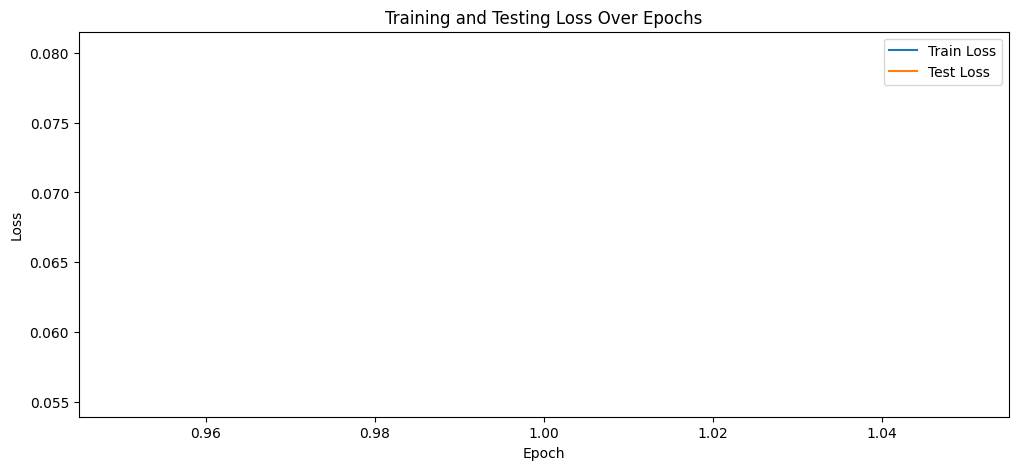

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004094606731086969
Inside training loop. Batch indices: 200000, loss value: 0.0066352710127830505
Inside training loop. Batch indices: 300000, loss value: 0.005593561101704836
Inside training loop. Batch indices: 400000, loss value: 0.0050121936947107315
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input100_target5_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 2
Epoch 2/100, Train Loss: 0.07683779970651951, Test Loss: 0.03267656319255462


<Figure size 640x480 with 0 Axes>

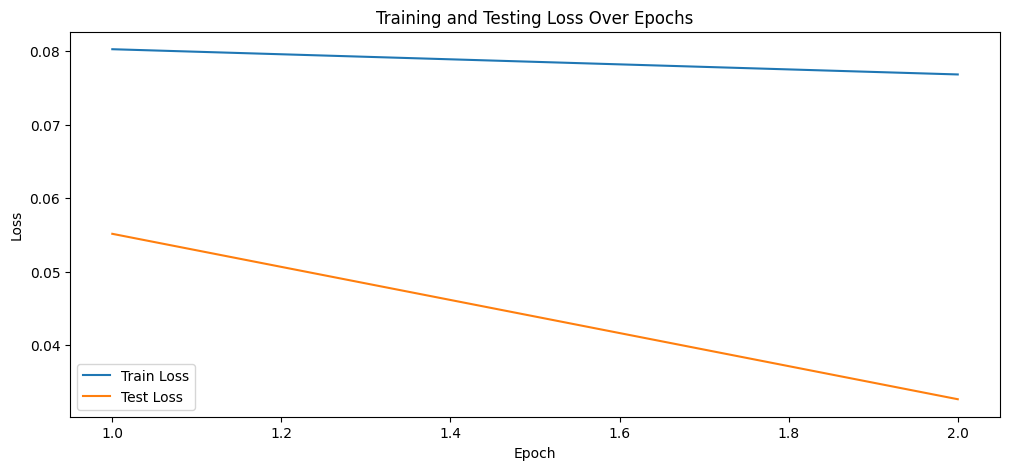

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004073645453900099
Inside training loop. Batch indices: 200000, loss value: 0.006603797432035208
Inside training loop. Batch indices: 300000, loss value: 0.005585352890193462
Inside training loop. Batch indices: 400000, loss value: 0.004982362035661936
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 3/100, Train Loss: 0.07647670401272239, Test Loss: 0.050911447179895965


<Figure size 640x480 with 0 Axes>

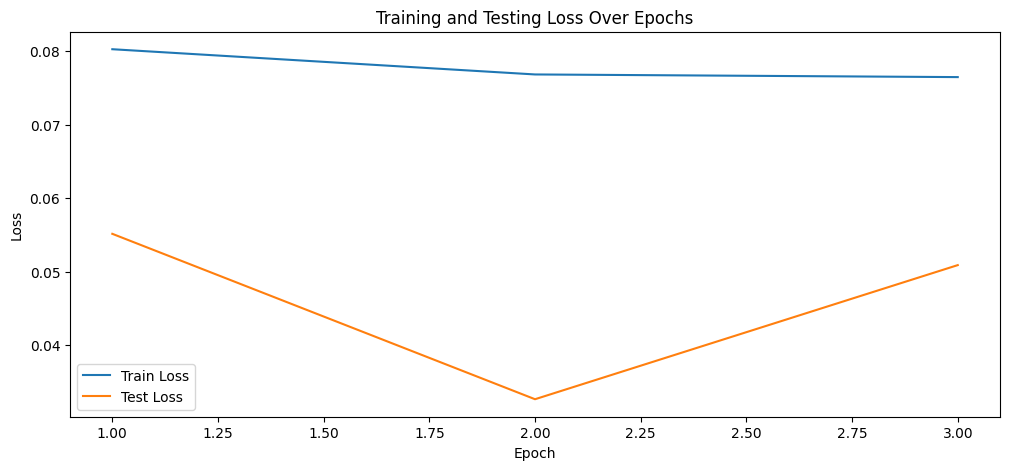

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004069127142429352
Inside training loop. Batch indices: 200000, loss value: 0.006616672035306692
Inside training loop. Batch indices: 300000, loss value: 0.005591273307800293
Inside training loop. Batch indices: 400000, loss value: 0.0050036306492984295
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input100_target5_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 4
Epoch 4/100, Train Loss: 0.0767207473261483, Test Loss: 0.019498381149634196


<Figure size 640x480 with 0 Axes>

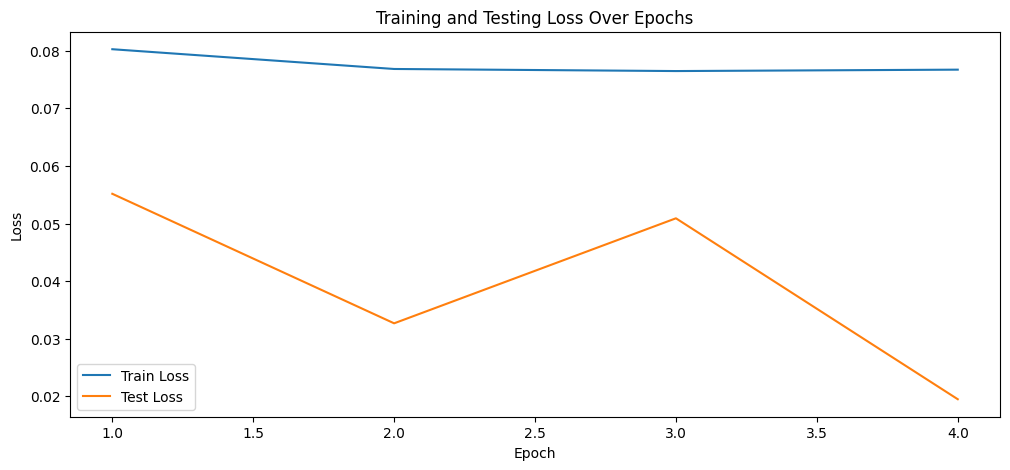

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004051527474075556
Inside training loop. Batch indices: 200000, loss value: 0.006615388207137585
Inside training loop. Batch indices: 300000, loss value: 0.0055845011956989765
Inside training loop. Batch indices: 400000, loss value: 0.004992896690964699
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 5/100, Train Loss: 0.0765753889135221, Test Loss: 0.021321887730253414


<Figure size 640x480 with 0 Axes>

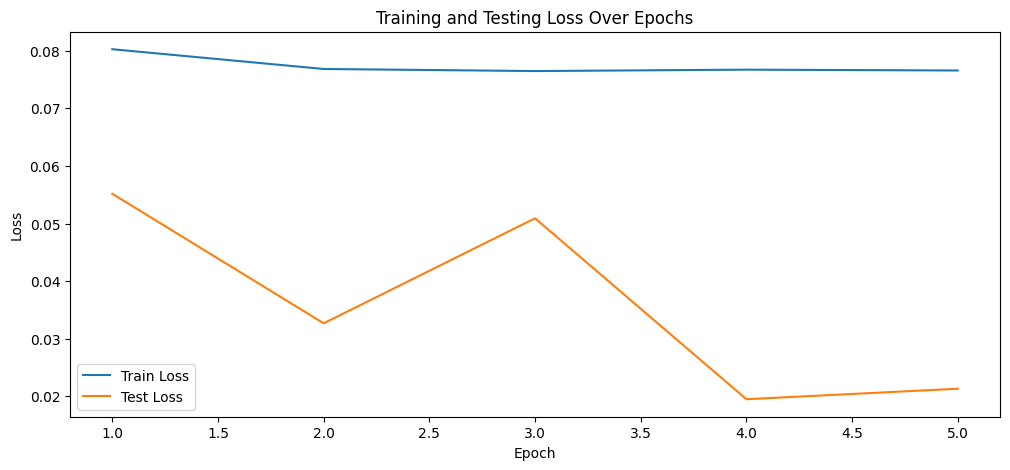

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004051510244607925
Inside training loop. Batch indices: 200000, loss value: 0.006613865960389376
Inside training loop. Batch indices: 300000, loss value: 0.00558706559240818
Inside training loop. Batch indices: 400000, loss value: 0.004982049576938152
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 6/100, Train Loss: 0.07642894068216659, Test Loss: 0.0635486189758056


<Figure size 640x480 with 0 Axes>

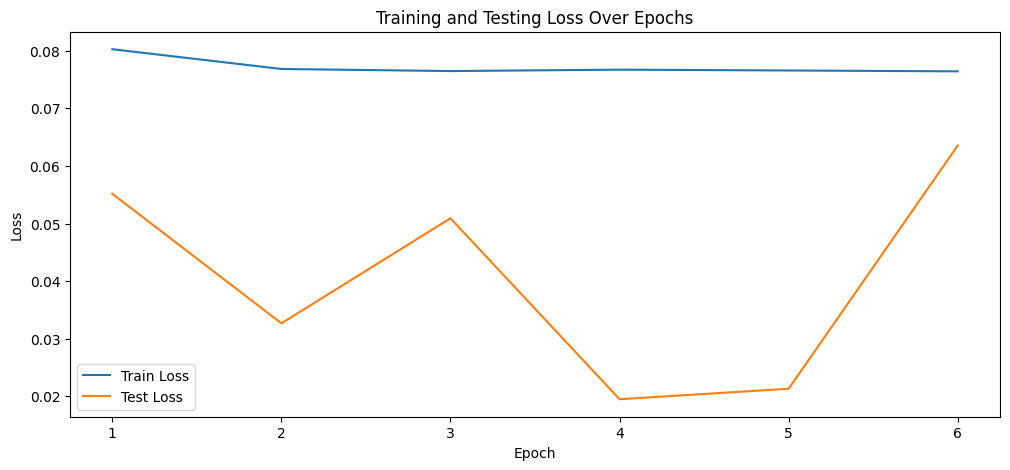

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004066739697009325
Inside training loop. Batch indices: 200000, loss value: 0.006643138825893402
Inside training loop. Batch indices: 300000, loss value: 0.005607989616692066
Inside training loop. Batch indices: 400000, loss value: 0.005013037472963333
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 7/100, Train Loss: 0.07704000720606917, Test Loss: 0.04966103703799573


<Figure size 640x480 with 0 Axes>

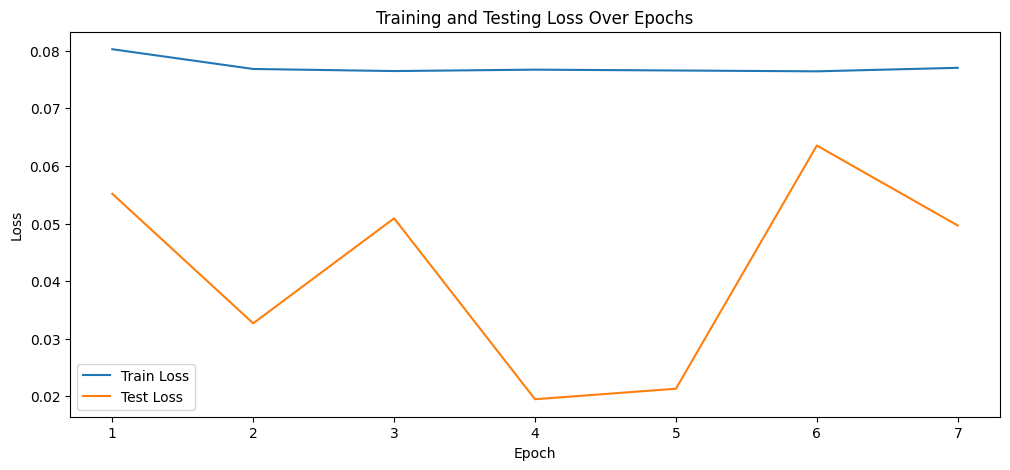

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0040644449181854725
Inside training loop. Batch indices: 200000, loss value: 0.006621079053729773
Inside training loop. Batch indices: 300000, loss value: 0.0055826762691140175
Inside training loop. Batch indices: 400000, loss value: 0.004995673894882202
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input100_target5_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 8
Epoch 8/100, Train Loss: 0.07660364321216882, Test Loss: 0.018994420885955016


<Figure size 640x480 with 0 Axes>

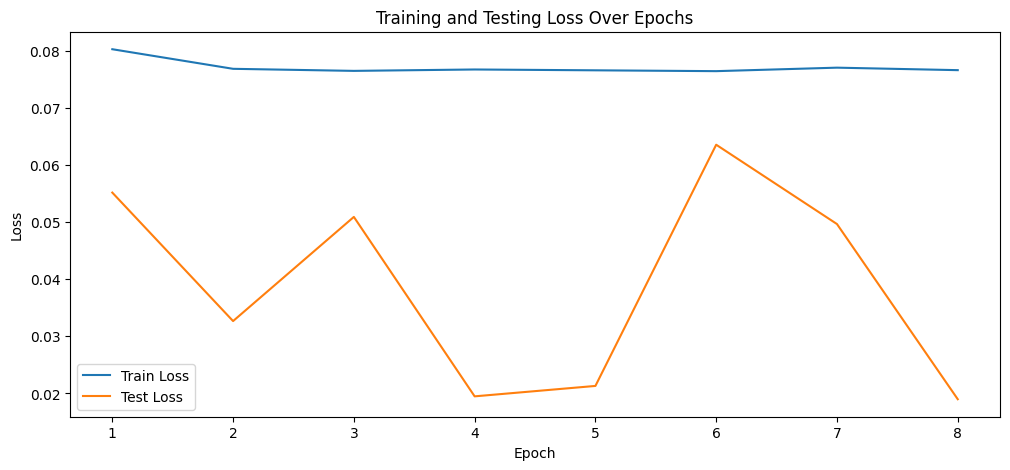

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004083359148353338
Inside training loop. Batch indices: 200000, loss value: 0.006631662603467703
Inside training loop. Batch indices: 300000, loss value: 0.005609781946986914
Inside training loop. Batch indices: 400000, loss value: 0.005007632542401552
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input100_target5_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 9
Epoch 9/100, Train Loss: 0.07697123748290256, Test Loss: 0.01887103750136559


<Figure size 640x480 with 0 Axes>

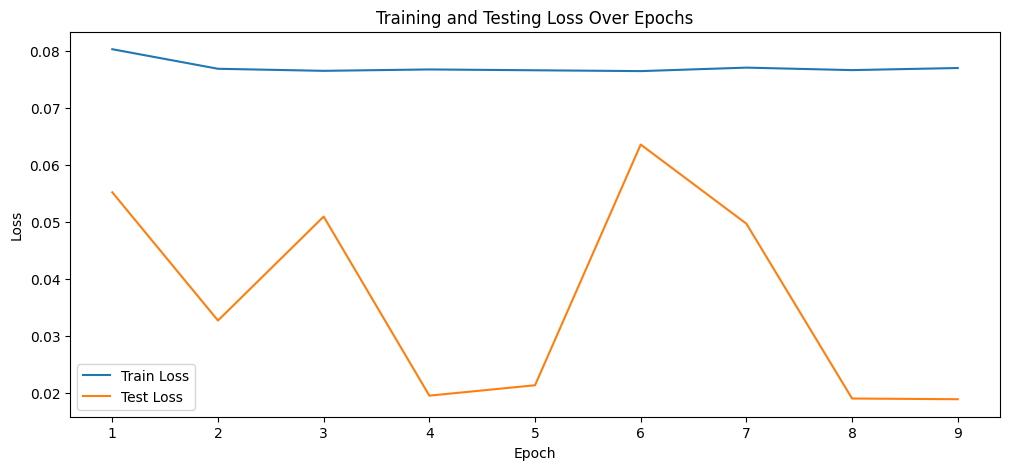

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004077706951647997
Inside training loop. Batch indices: 200000, loss value: 0.006643545348197222
Inside training loop. Batch indices: 300000, loss value: 0.005617775022983551
Inside training loop. Batch indices: 400000, loss value: 0.00501511013135314
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 10/100, Train Loss: 0.07688587759515532, Test Loss: 0.019977504666991868


<Figure size 640x480 with 0 Axes>

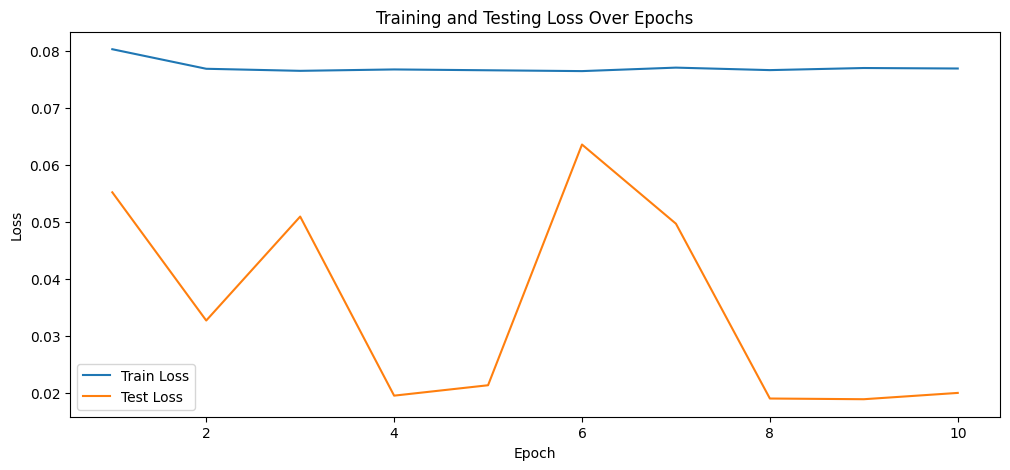

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004070846363902092
Inside training loop. Batch indices: 200000, loss value: 0.006593581289052963
Inside training loop. Batch indices: 300000, loss value: 0.005565289407968521
Inside training loop. Batch indices: 400000, loss value: 0.00497960252687335
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 11/100, Train Loss: 0.0765230930384092, Test Loss: 0.024367122571681693


<Figure size 640x480 with 0 Axes>

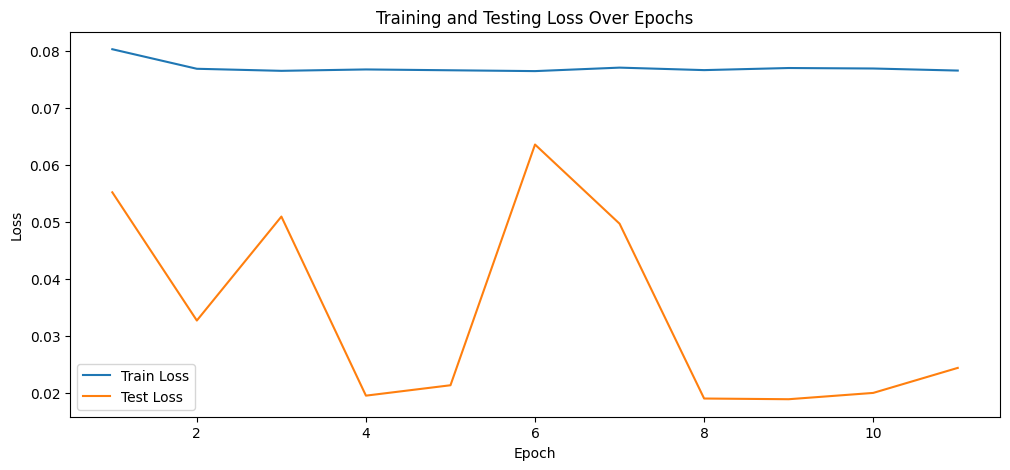

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004083333536982536
Inside training loop. Batch indices: 200000, loss value: 0.006654728669673204
Inside training loop. Batch indices: 300000, loss value: 0.005628996528685093
Inside training loop. Batch indices: 400000, loss value: 0.005018208175897598
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 12/100, Train Loss: 0.07711259738798718, Test Loss: 0.07045282768448452


<Figure size 640x480 with 0 Axes>

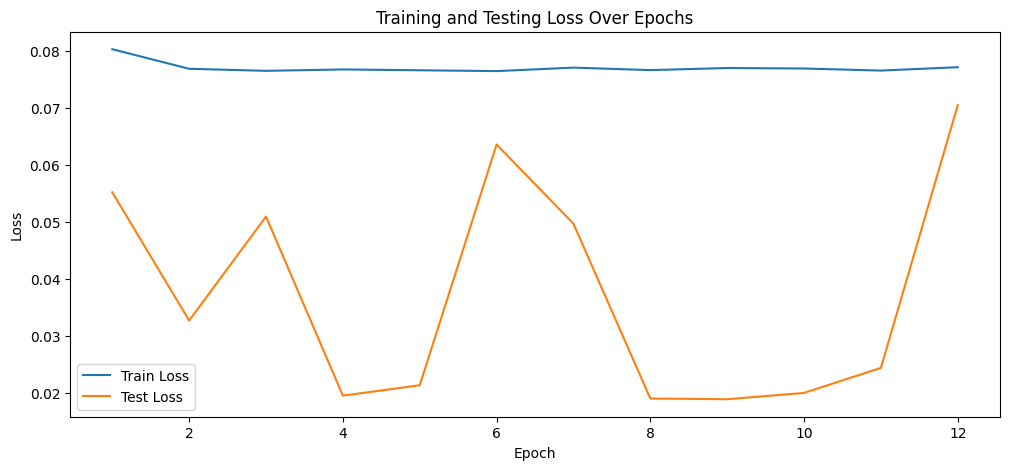

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004092036746442318
Inside training loop. Batch indices: 200000, loss value: 0.006641709245741367
Inside training loop. Batch indices: 300000, loss value: 0.005603825207799673
Inside training loop. Batch indices: 400000, loss value: 0.005005121696740389
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 13/100, Train Loss: 0.07683405218877523, Test Loss: 0.020328162785183533


<Figure size 640x480 with 0 Axes>

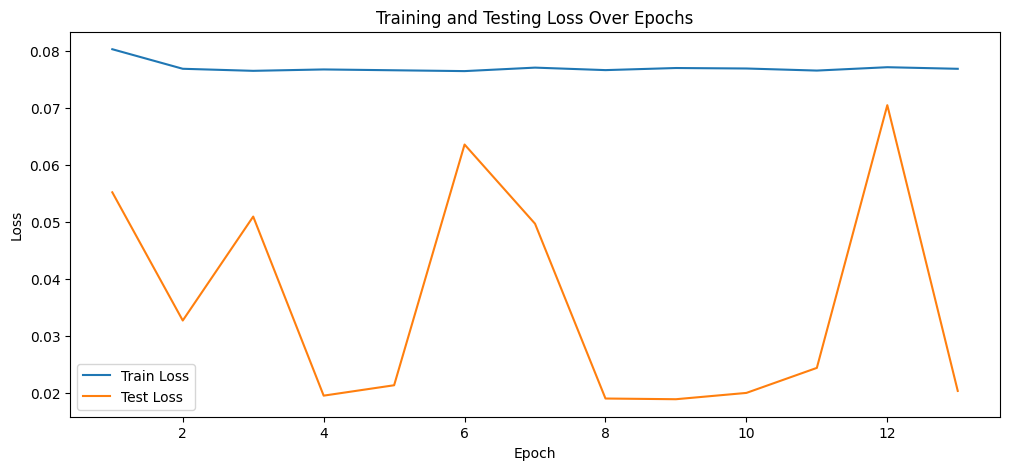

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004078378435224295
Inside training loop. Batch indices: 200000, loss value: 0.00669472711160779
Inside training loop. Batch indices: 300000, loss value: 0.005633635446429253
Inside training loop. Batch indices: 400000, loss value: 0.005030427593737841
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 14/100, Train Loss: 0.07713112967461795, Test Loss: 0.01947619515345998


<Figure size 640x480 with 0 Axes>

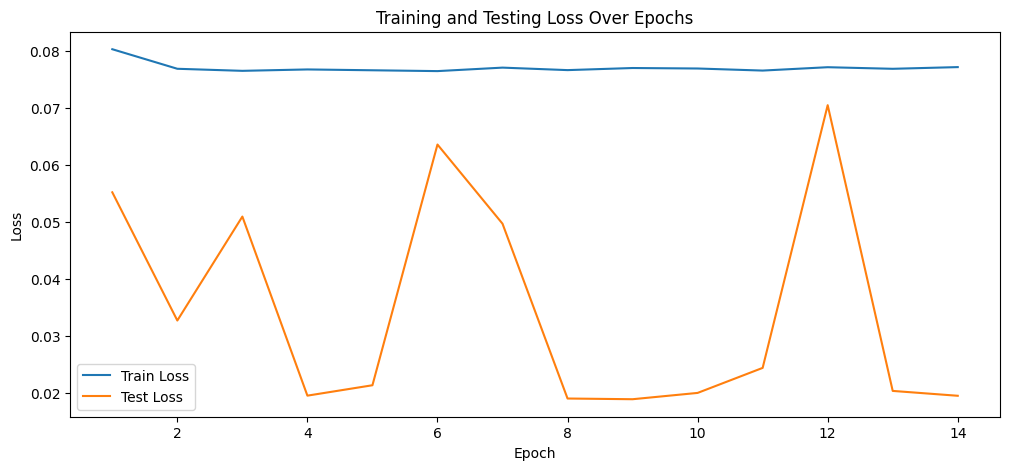

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004078315105289221
Inside training loop. Batch indices: 200000, loss value: 0.006627778057008982
Inside training loop. Batch indices: 300000, loss value: 0.005590342916548252
Inside training loop. Batch indices: 400000, loss value: 0.005002304911613464
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 15/100, Train Loss: 0.07692433556626778, Test Loss: 0.025566683876976554


<Figure size 640x480 with 0 Axes>

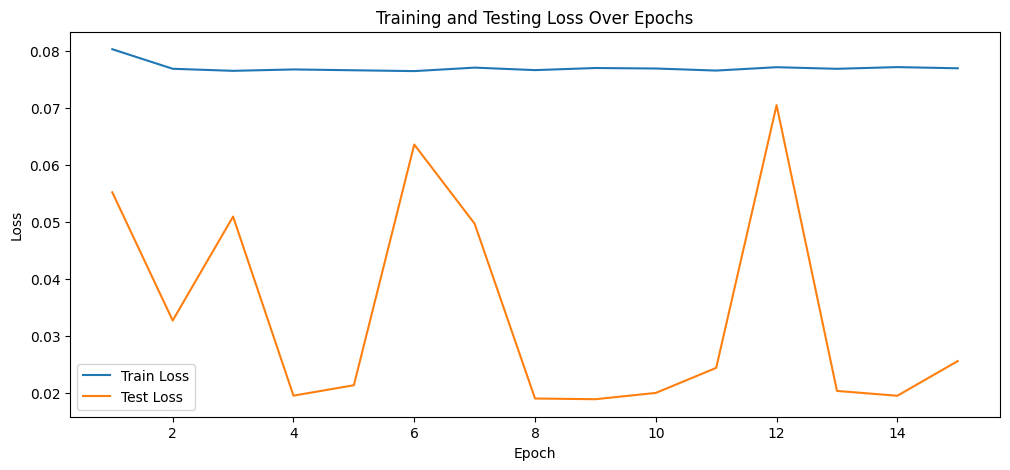

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.00406249426305294
Inside training loop. Batch indices: 200000, loss value: 0.0066216071136295795
Inside training loop. Batch indices: 300000, loss value: 0.005584341939538717
Inside training loop. Batch indices: 400000, loss value: 0.004993002396076918
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 16/100, Train Loss: 0.07673979674216924, Test Loss: 0.03726342356826847


<Figure size 640x480 with 0 Axes>

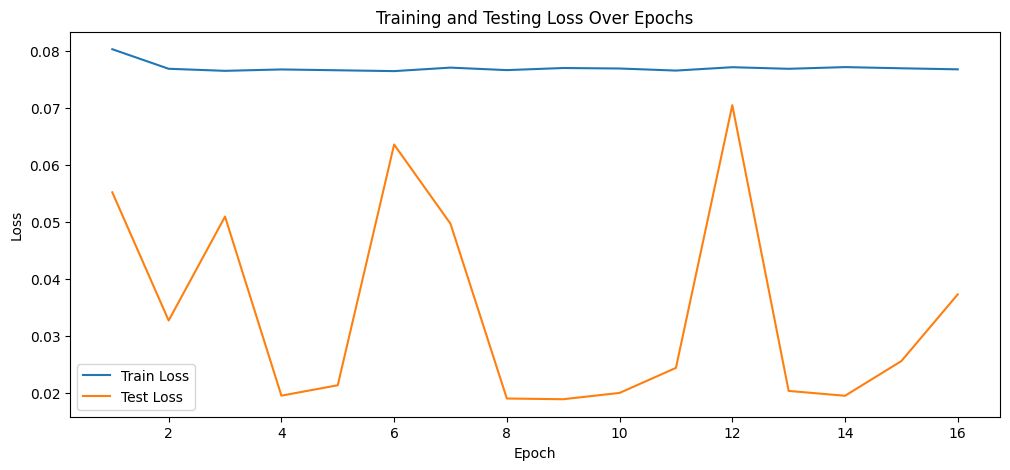

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.004067237954586744


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [47]:
def create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers):
    return f"model_input{input_size}_target{target_size}_dmodel{d_model}_nheads{n_heads}_encoderlayers{num_encoder_layers}_lstmhidden{lstm_hidden_size}_lstmlayers{num_lstm_layers}.pth"

# 모델 파일 경로
model_file_path = f"model/final v2/{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}"

# 모델 파일이 존재하는지 확인하고, 존재할 경우 모델 로드
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path))
    print("Pre-trained model loaded.")
else:
    print("No pre-trained model found. Initializing a new model.")

# 학습 과정
train_losses = []
test_losses = []
best_test_loss = float('inf')

# Define the directory for saving figures
figures_directory = "figures/final v2"
model_name = create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers).replace('.pth', '')  # Use the generated model name without the file extension
model_figures_directory = os.path.join(figures_directory, model_name)

# Create the directories if they do not exist
os.makedirs(model_figures_directory, exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Update best test loss and save model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), model_file_path)
        print(f"Model saved as '{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}' at Epoch {epoch + 1}")

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")


    # Plotting
    plt.figure(figsize=(12, 5))

    # 학습 과정 시각화
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()

    # Save the figure before calling show
    figure_path = os.path.join(model_figures_directory, f"Epoch_{epoch+1}.png")
    plt.savefig(figure_path)

    # Then display the plot
    plt.show()

    # Clear the figure after displaying it to prepare for the next plot if this is not the last epoch
    plt.clf()




    # # Plot training loss
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.legend()

    # # Plot testing loss
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Testing Loss Over Epochs')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()